# Bottleneck analysis

When analyzing the resource estimates of a given quantum program, `bartiq` allows us to identify how these values are being constructed. The recursive, tree-like structure of `bartiq` `Routines` means that finding _algorithmic bottlenecks_ is straightforward. An algorithmic bottleneck refers to a particular subroutine that, perhaps unexpectedly, demands a significant portion of our total resource budget. 

This type of analysis allows us to target our research efforts onto particularly costly subroutines. By highlighting where our logical resource budget is being spent, we may be able to improve our algorithms further.

Bottleneck analysis is easiest with numeric routines, as comparing symbolic expressions can be tricky. Here, we load in the Double Factorization routine and evaluate it for a given physical system.

In [1]:
from bartiq import CompiledRoutine, sympy_backend, evaluate
import yaml

with open("./double_factorization_compiled.yaml", "r") as f:
    compiled_routine = CompiledRoutine.from_qref(yaml.safe_load(f), sympy_backend)

assignments = {
    "N_spatial": 35,
    "M_r": 25,
    "R": 298,
    "b_as": 10,
    "b_mas": 10,
    "b_givens": 20,
    "lambda": 4,
}
df = evaluate(compiled_routine, assignments=assignments).routine

We can see the exact resource estimates when we call `.resource_values`:

In [2]:
df.resource_values

{'active_volume': 9216517.5,
 'gidney_lelbows': 18320,
 'gidney_relbows': 18320,
 'measurements': 5788,
 'ppms': 0,
 'pprs': 272,
 'qubit_highwater': 2937,
 'rotations': 21,
 't_gates': 217,
 'toffs': 7263}

For this exercise we'll look at the **active volume** resource. Which subroutine(s) are contributing the  most active volume?

The following snippet traverses the `.children` property of `df`, our `CompiledRoutine`, and returns a list of tuples: the name of the subroutine (or `child`) and its individual active volume contribution.

In [3]:
{
    child_name: av
    for child_name, child_routine in df.children.items()
    if (av := child_routine.resource_values.get("active_volume", None))
}

{'RotationCatalystStatePrep_compute_0': 23842.5,
 'LCU_compute_0': 9191893,
 'z_0': 782}

`LCU_compute_0` ('LCU' referring to the process of [linear combination of unitaries](https://pennylane.ai/qml/demos/tutorial_lcu_blockencoding)) is far and away the dominant contribution of active volume _at this level_. Because quantum algorithms are defined recursively (i.e. nested circuit operations), by running the same snippet on the `LCU_compute_0` `CompiledRoutine` object, we would get a more fine-grained view of the resource contributions.

Below is a helper function that accepts in a compiled routine object, and an optional resource name, and returns the contributions of the child routines.

In [4]:
def child_contributions_to_parent_resource(
    routine: CompiledRoutine, resource: str = "active_volume"
) -> dict[str, int | float]:
    """For a given routine and resource, return the resource cost of its children.

    Arguments
    ----------
    routine
        A bartiq CompiledRoutine object.
    resource
        Which resource to investigate, by default 'active_volume'. Any children that do not have this resource
        are not included in the output.

    Returns
    -------
        A dictionary of children names and their individual resource costs.
    """
    return {
        child_name: resource_value
        for child_name, child_routine in routine.children.items()
        if (resource_value := child_routine.resource_values.get(resource, None))
    }

## Visualization

Bottleneck analysis is a process where visualization can be particularly useful.
Consider the following:
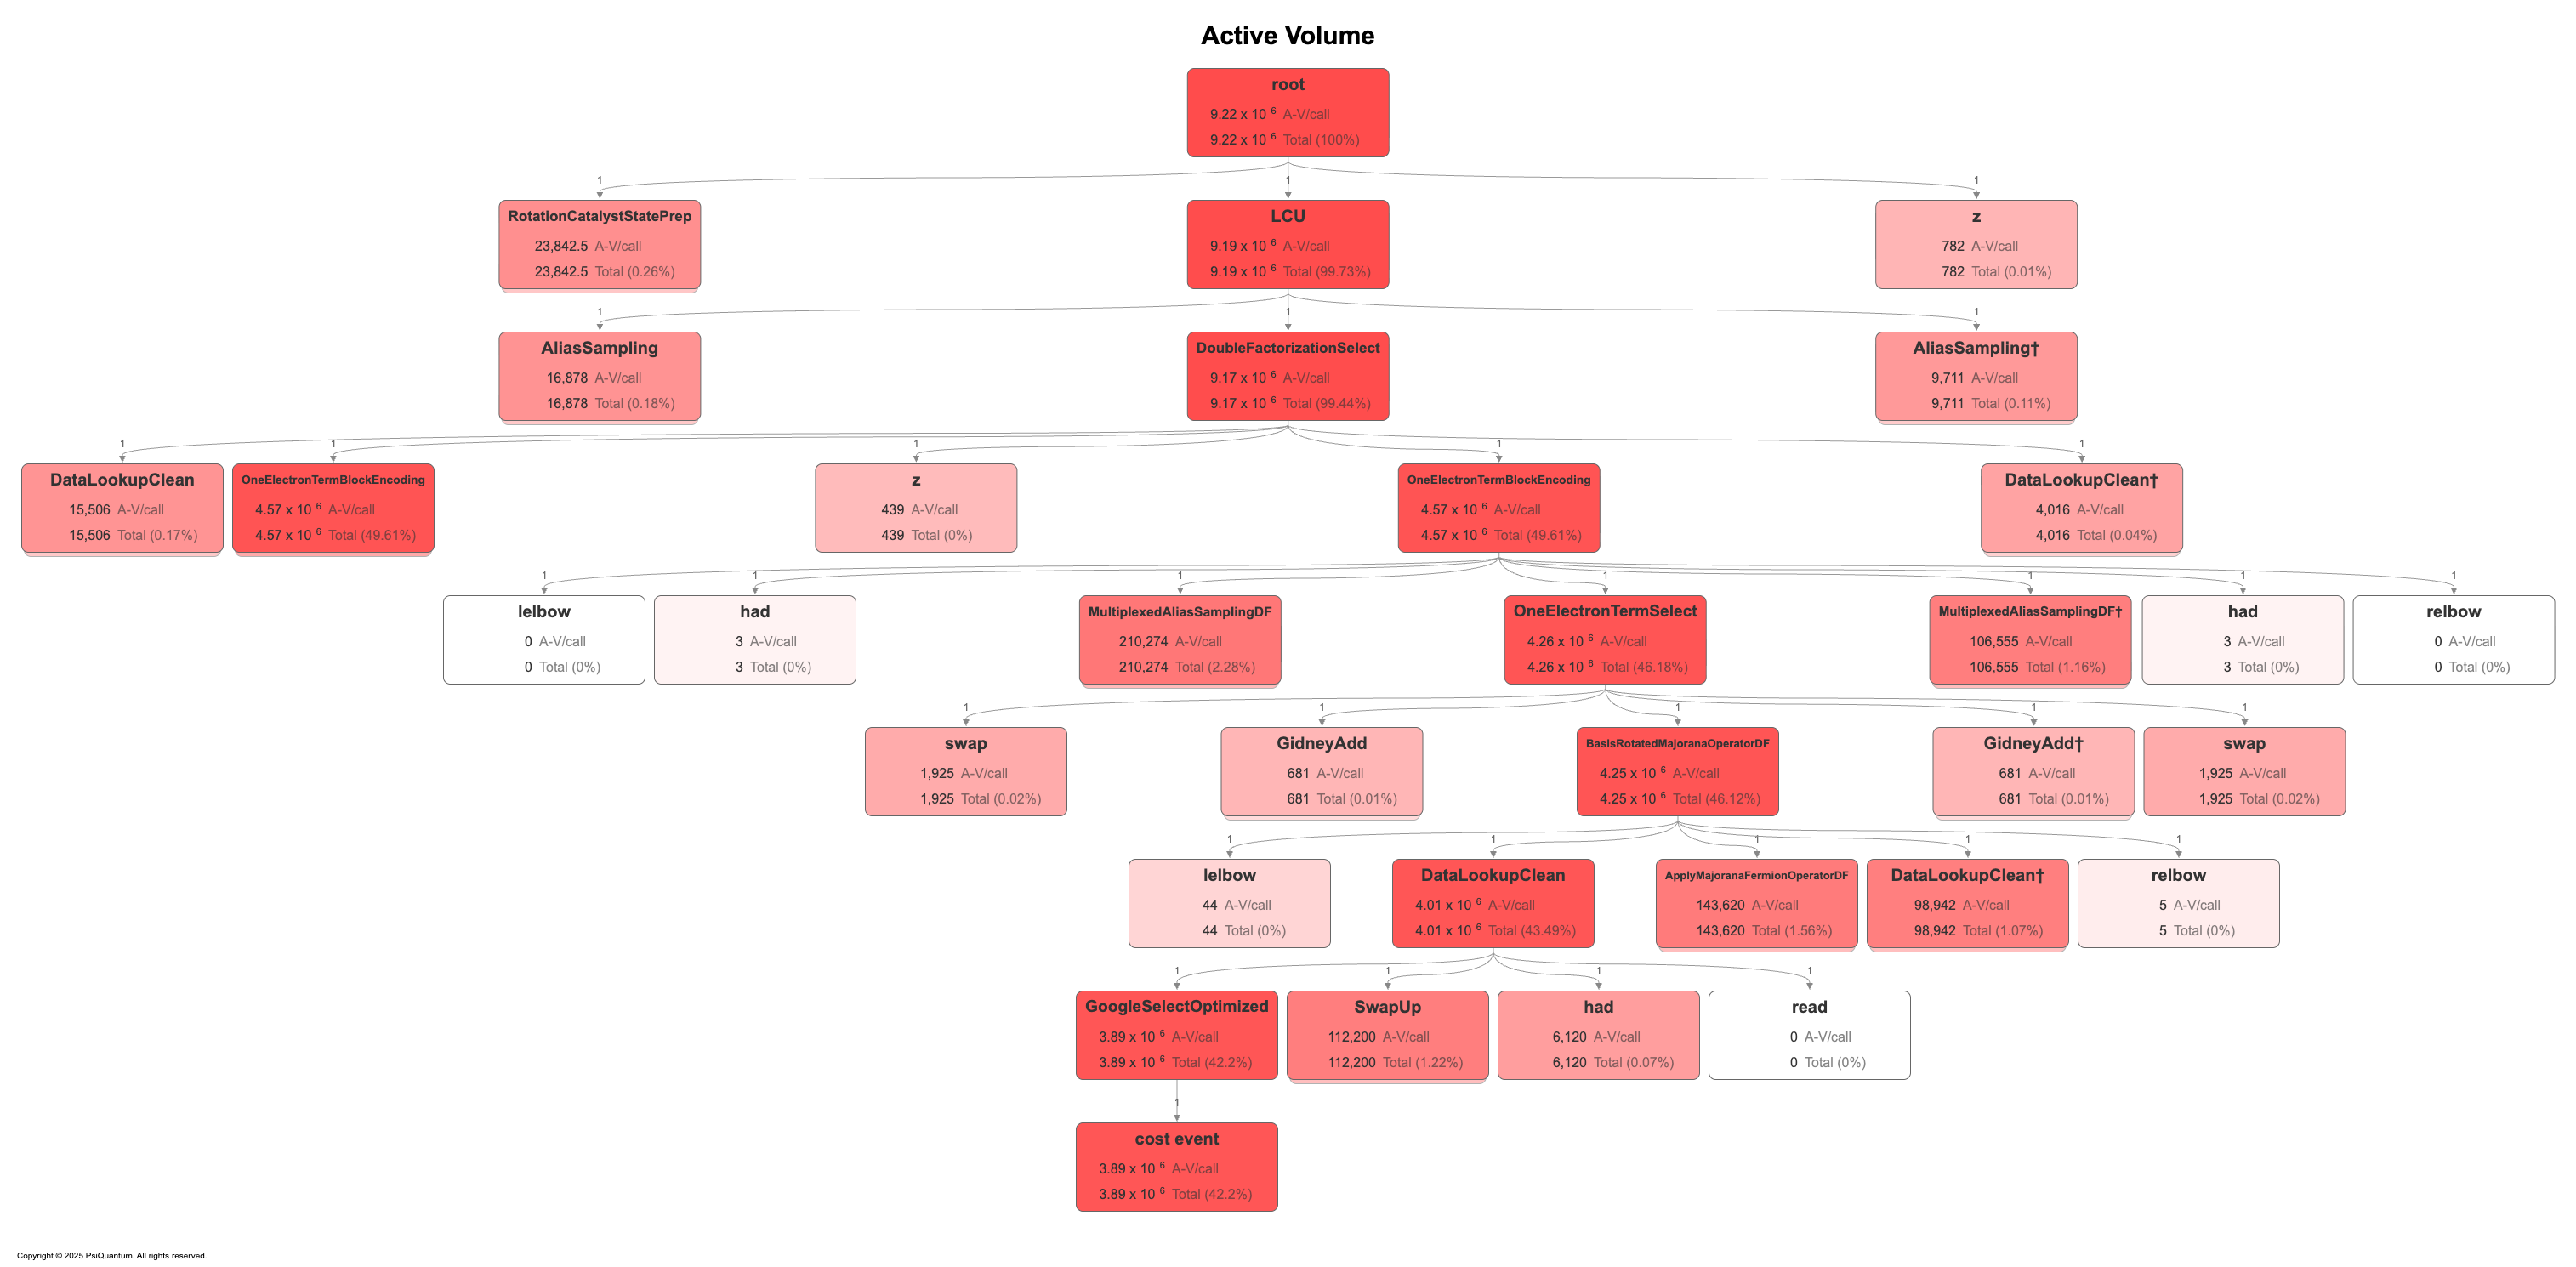

This is a call graph for Double Factorization routine. You might notice a couple of things about it:
- the more intense the color, the higher resource count is
- we have only expanded the nodes which have the highest costs
- the names of the subroutines are slightly modified from the ones we've seen above (for better readability)

Such graph corresponds to the hierarchical structure of Bartiq's routine – you can see that the root node has three children contributing to its AV cost:

In [5]:
child_contributions_to_parent_resource(df, resource="active_volume")

{'RotationCatalystStatePrep_compute_0': 23842.5,
 'LCU_compute_0': 9191893,
 'z_0': 782}

Now if we look at the children contributions for `LCU_compute_0` we'll see:

In [6]:
child_contributions_to_parent_resource(df.children["LCU_compute_0"], resource="active_volume")

{'AliasSampling_compute_0': 16878,
 'DoubleFactorizationSelect_compute_0': 9165304,
 'AliasSampling_uncompute_0': 9711}

Now try to see what are the contributions for the routine named "OneElectronTermBlockEncoding" in the call graph above:

In [7]:
# Modify the following line further to get to the routine of interest!
subroutine = df.children["LCU_compute_0"] #.children["..."]
child_contributions_to_parent_resource(subroutine, resource="active_volume")

{'AliasSampling_compute_0': 16878,
 'DoubleFactorizationSelect_compute_0': 9165304,
 'AliasSampling_uncompute_0': 9711}

## Exercise

Write a script that recursively finds the most expensive subroutine, and the names of the all the subroutines encountered on the way there.

Conceptually, it would be sth like this:
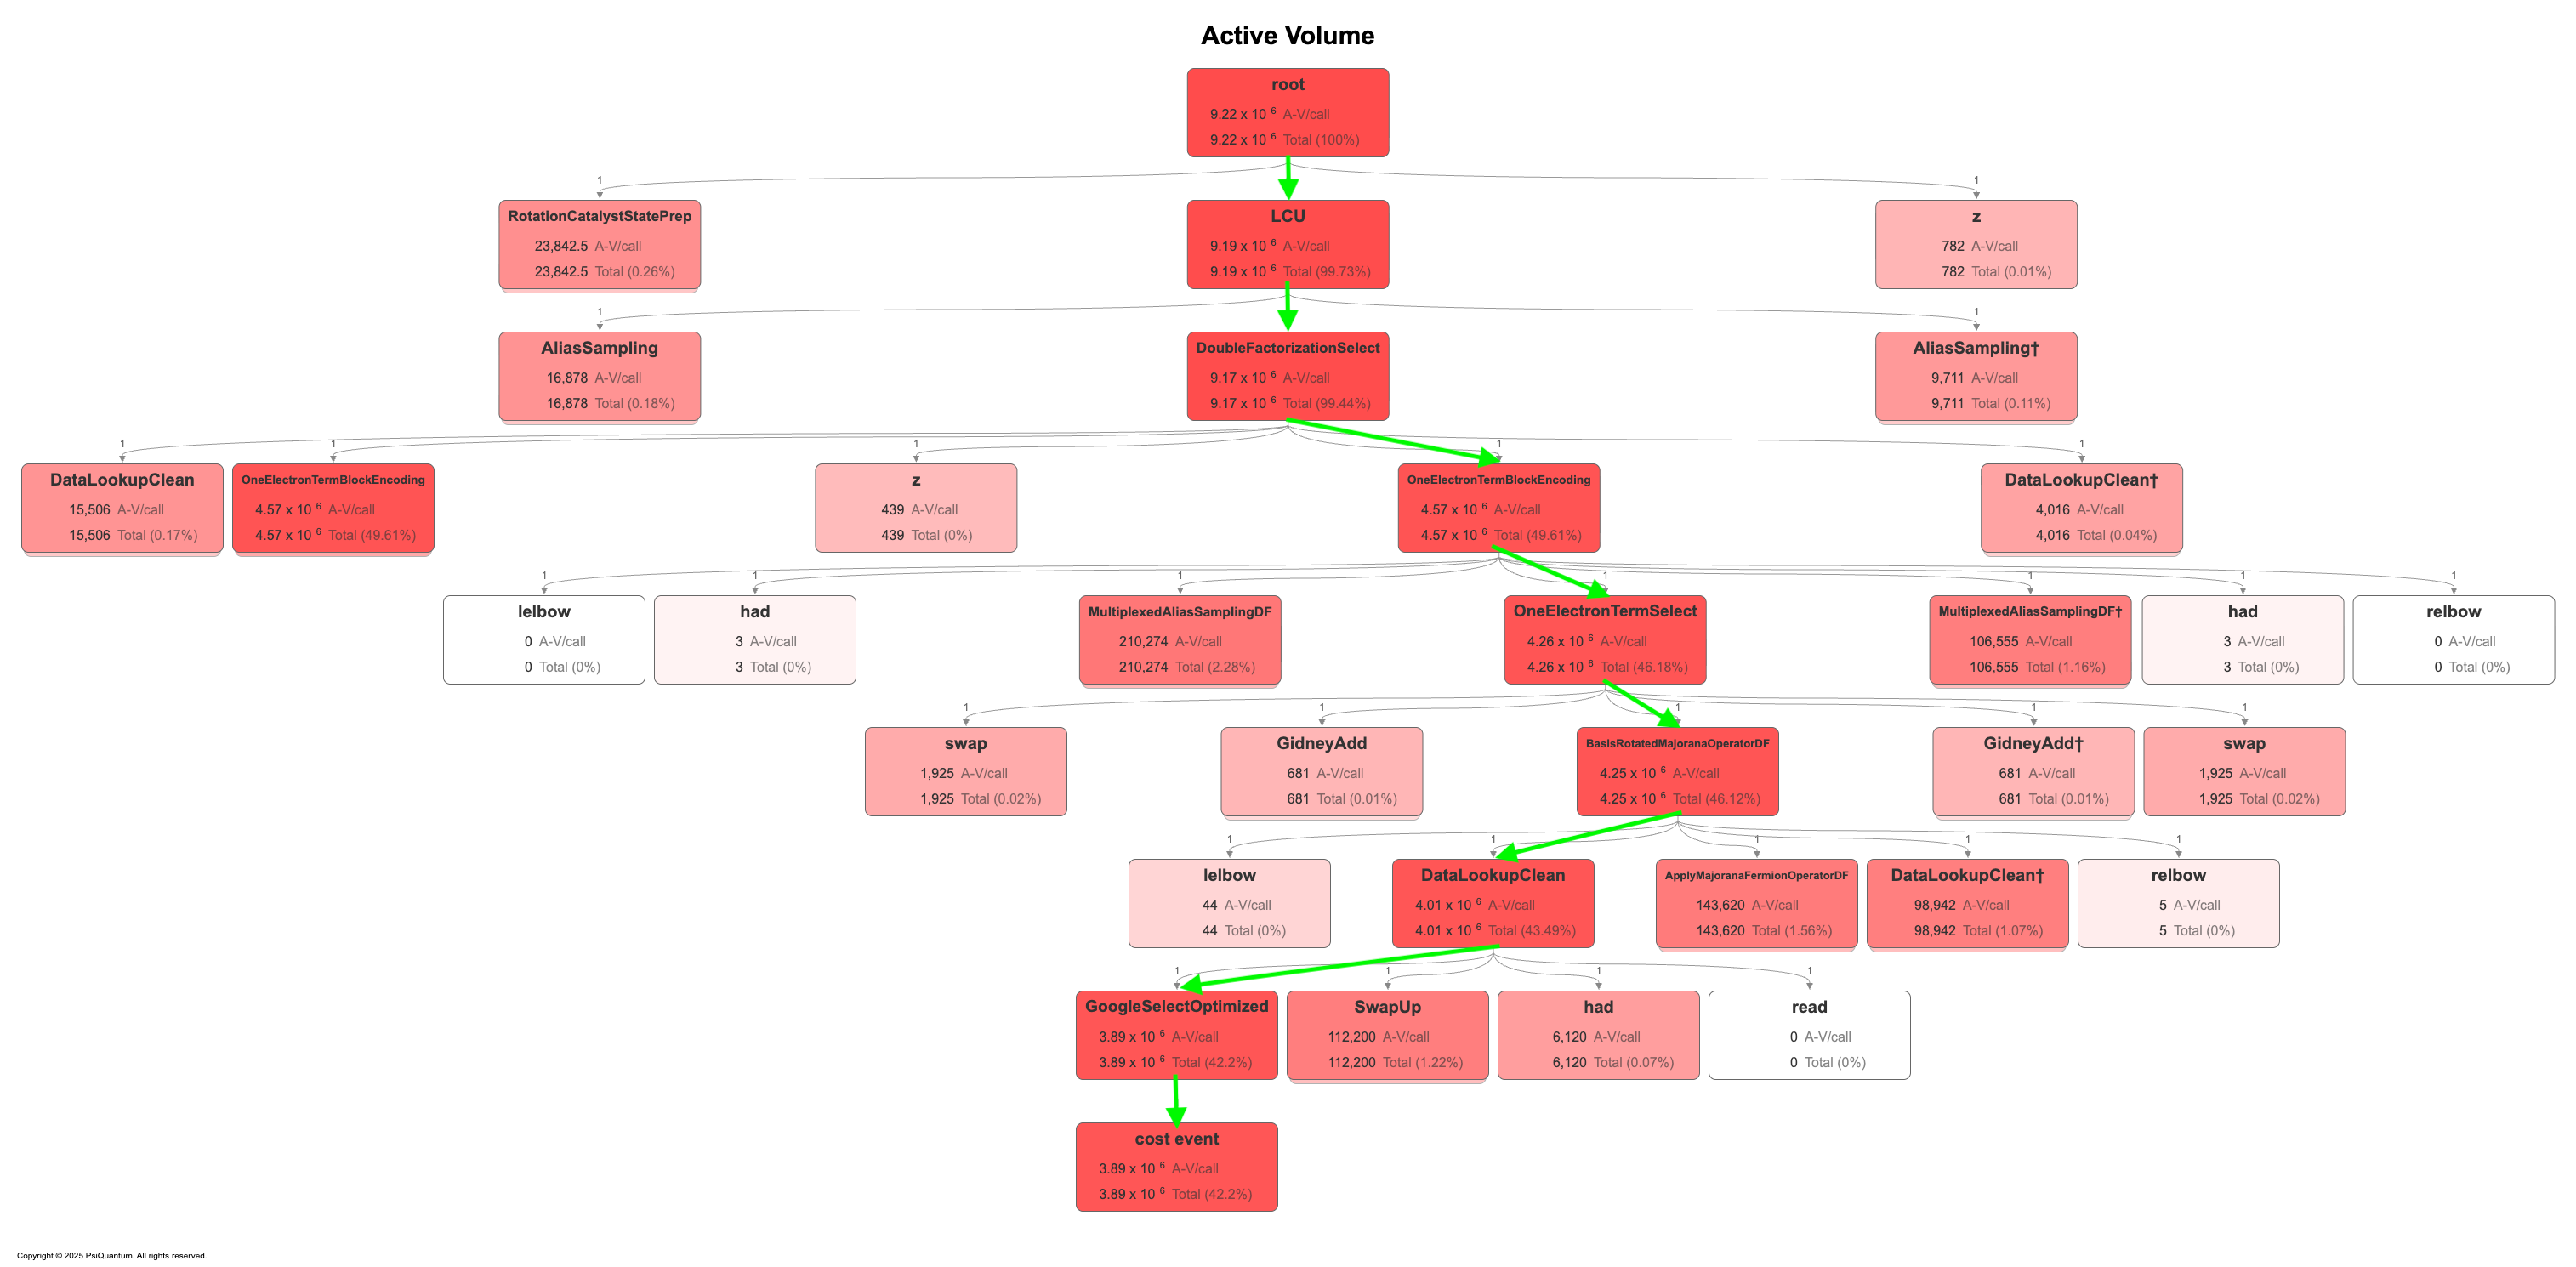

In [8]:
def find_most_expensive(routine: CompiledRoutine, path: list[str]):
    # Write your code here
    pass

In [9]:
find_most_expensive(df, [])

**Bonus task**

Find the pathway to the _second_ absolute most expensive leaf subroutine (i.e. one that doesn't have any children on its own).